In [240]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, medfilt

In [241]:
# Load in a dataset
datasets = [pd.read_csv("distance-benchmarks-1.csv"),
            pd.read_csv("distance-benchmarks-2.csv"),
            pd.read_csv("distance-benchmarks-3.csv"),
            pd.read_csv("distance-benchmarks-4.csv")]
dataset = pd.concat(datasets)
print(dataset)

       Item1.X  Item1.Y  Item1.Brightness        Item2
0            0        0               116  2554.720032
1            0        0               115  2554.730016
2            0        0               116  2554.740032
3            0        0               116  2554.750016
4            0        0               116  2554.760032
...        ...      ...               ...          ...
21430        0        0               122  3466.100032
21431        0        0               117  3466.110016
21432        0        0               121  3466.120032
21433        0        0               120  3466.130016
21434        0        0               122  3466.140032

[83980 rows x 4 columns]


Text(0, 0.5, 'Optical flow reading')

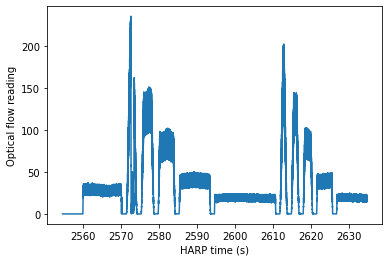

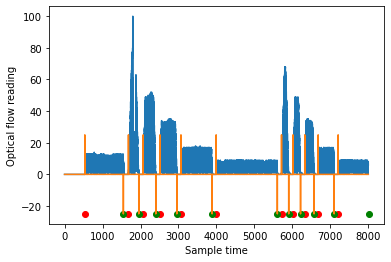

In [261]:
# Preprocessing
preview_range = np.arange(0, 8000)
x_motion = np.array(dataset["Item1.X"])
time_base = np.array(dataset["Item2"])
x_diff = np.diff(x_motion)

# signal envelope
filtered = np.abs(medfilt(x_motion, 101))
filtered[filtered < 2] = 0
filtered[filtered > 0] = 25
on_signal = np.diff(filtered)
on_times = find_peaks(on_signal, height=1)[0]
off_times = find_peaks(-on_signal, height=1)[0]

# Show example data
plt.figure()
plt.plot(time_base[preview_range], np.abs(x_motion[preview_range]))
plt.xlabel("HARP time (s)")
plt.ylabel("Optical flow reading")

# Show trial extraction preview
plt.figure()
plt.plot(np.abs(x_diff[preview_range]))
plt.plot(on_signal[preview_range])
plt.scatter(on_times[0:11], -np.ones(len(on_times[0:11])) * 25, c='r')
plt.scatter(off_times[0:11], -np.ones(len(off_times[0:11])) * 25, c='g')
plt.xlabel("Sample time")
plt.ylabel("Optical flow reading")


In [262]:
# organise by trial, 0 represents homing trials
# trial types for 1 experiment
distances = np.array([0, 400, 400, 400, 400, 400, 200, 200, 200, 200, 200, 100, 100, 100, 100, 100, 50, 50, 50, 50, 50, -400, -400, -400, -400, -400, -200, -200, -200, -200, -200, -100, -100, -100, -100, -100, -50, -50, -50, -50, -50])
velocities = np.array([0, 250, 150, 100, 50, 25, 250, 150, 100, 50, 25, 250, 150, 100, 50, 25, 250, 150, 100, 50, 25, 250, 150, 100, 50, 25, 250, 150, 100, 50, 25, 250, 150, 100, 50, 25, 250, 150, 100, 50, 25])

distances = np.tile(distances, len(datasets))
velocities = np.tile(velocities, len(datasets))

trial_on_times = on_times[velocities > 0] # exclude homing trials
trial_off_times = off_times[velocities > 0]
distances = distances[velocities > 0]
velocities = velocities[velocities > 0]

# check trial matching
assert len(trial_on_times) == len(trial_off_times), "Mismatch trial times"
assert len(trial_on_times) == len(distances) == len(velocities), "Mismatch trial number"

Text(0, 0.5, 'Optical flow integral')

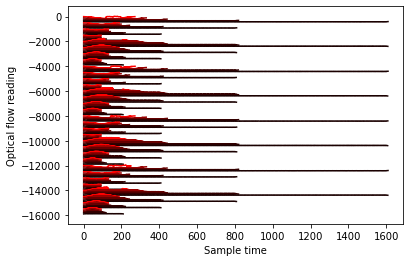

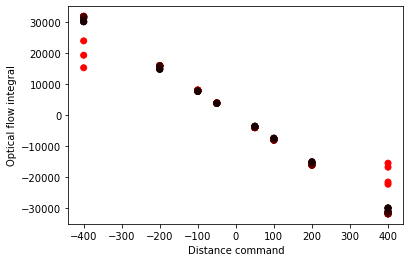

In [264]:
# stats for each trial + sanity check plot
distance_integral = list()
cmap = list(map(lambda v: (v / np.max(velocities), 0, 0), velocities))

plt.figure()
for t_index in range(len(trial_on_times)):
    signal_period = x_motion[trial_on_times[t_index]:trial_off_times[t_index]]
    distance_integral.append(np.sum(signal_period))
    plt.plot(signal_period + (t_index*-100), c=cmap[t_index])
plt.xlabel("Sample time")
plt.ylabel("Optical flow reading")

distance_integral = np.array(distance_integral)

plt.figure()
plt.scatter(distances, distance_integral, c=cmap)
plt.xlabel("Distance command")
plt.ylabel("Optical flow integral")


In [260]:
for d in np.unique(distances):
    var_at_d = np.std(distance_integral[distances == d])
    print(d, var_at_d)

-400 4469.00160438548
-200 419.6931140726519
-100 146.23059700349992
-50 41.52454093665576
50 158.6452883006615
100 217.90944793652244
200 386.7446961497986
400 5080.2004239498265
